In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import camera_calibration_show_extrinsics as show
from PIL import Image
import random

Start finding chessboard corners...
find the chessboard corners of data/0000.jpg
find the chessboard corners of data/0001.jpg
find the chessboard corners of data/0002.jpg
find the chessboard corners of data/0003.jpg
find the chessboard corners of data/0004.jpg
find the chessboard corners of data/0005.jpg
find the chessboard corners of data/0006.jpg
find the chessboard corners of data/0007.jpg
find the chessboard corners of data/0008.jpg
find the chessboard corners of data/0009.jpg


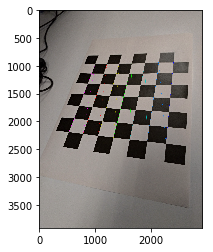

In [2]:
corner_x = 7
corner_y = 7
objp = np.zeros((corner_x*corner_y,3), np.float32)
objp[:,:2] = np.mgrid[0:corner_x, 0:corner_y].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space (10,49,3)
imgpoints = [] # 2d points in image plane. (10,49,1,2)

# Make a list of calibration images
images = glob.glob('data/*.jpg')
images = sorted(images)

# Step through the list and search for chessboard corners
print('Start finding chessboard corners...')
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    plt.imshow(gray)

    #Find the chessboard corners
    print('find the chessboard corners of',fname)
    ret, corners = cv2.findChessboardCorners(gray, (corner_x,corner_y), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        cv2.drawChessboardCorners(img, (corner_x,corner_y), corners, ret)
        plt.imshow(img)


In [3]:
def v(i, j, H):
    v0 = H[0,i] * H[0,j]
    v1 = H[0,i] * H[1,j] + H[1,i] * H[0,j]
    v2 = H[1,i] * H[1,j]
    v3 = H[2,i] * H[0,j] + H[0,i] * H[2,j]
    v4 = H[2,i] * H[1,j] + H[1,i] * H[2,j]
    v5 = H[2,i] * H[2,j]
    v_ij = np.array([v0, v1, v2, v3, v4, v5])
    return v_ij

### correct H

In [4]:
img_size = (img.shape[1], img.shape[0])
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)
Vr = np.array(rvecs)
Tr = np.array(tvecs)
RTcorr = np.zeros((len(objpoints),3,3))
Hcorr = np.zeros((len(objpoints),3,3))
for i in range(len(objpoints)):
    rcorr, _ = cv2.Rodrigues(Vr[i])
    RTcorr[i] = np.concatenate((rcorr[:,0:2],Tr[i]), axis=1)
    Hcorr[i] = mtx.dot(RTcorr[i])

In [5]:
def ransac(kp1,kp2,error_threshold):
    #print(kp2)
    iterations = 1000
    n=3
    most_consensus_number = 0 #correspond keypoint counter
    kp_num = len(kp1)
    #list to matrix
    kp1_matrix = np.zeros((3,kp_num), dtype="f")
    kp2_matrix = np.zeros((3,kp_num), dtype="f")
    for m in range(kp_num):
        kp1_matrix[0][m] = kp1[m][0]
        kp1_matrix[1][m] = kp1[m][1]
        kp1_matrix[2][m] = 1
        kp2_matrix[0][m] = kp2[m][0][0]
        kp2_matrix[1][m] = kp2[m][0][1]
        kp2_matrix[2][m] = 1

    for i in range(iterations):
        kp1_rand = np.zeros((n,2), dtype="f")
        kp2_rand = np.zeros((n,2), dtype="f")
        while np.array_equal(kp1_rand[0],kp1_rand[1]) or np.array_equal(kp1_rand[0],kp1_rand[2]) or np.array_equal(kp1_rand[1],kp1_rand[2]):
            for j in range(n):
                rand = random.randint(0,kp_num-1)
                kp1_rand[j,0]=kp1[rand][0]
                kp1_rand[j,1]=kp1[rand][1]
                kp2_rand[j,0]=kp2[rand][0][0]
                kp2_rand[j,1]=kp2[rand][0][1]
        #use 3 keypoit to compute transform matrix
        M = cv2.getAffineTransform(kp1_rand, kp2_rand)
        M_stack = np.row_stack((M, [0,0,1])) #transform matrix[a,b,c;d,e,f;0,0,1]
        #transform all kp1 by the matrix
        kp1_transform = np.dot(M_stack,kp1_matrix)
        error = kp2_matrix - kp1_transform
        error = error[0:2].transpose()
        #cumpute mean square
        mean_square = np.sqrt(np.sum(np.square(error),axis=1)/2.)
        index = np.where(mean_square < error_threshold) #return tuple,there is an array in tuple
        consensus_num = index[0].shape[0]
        #update parameter and least_mean_square
        if consensus_num > most_consensus_number:
            better_kp1 = []
            better_kp2 = []
            most_consensus_number = consensus_num
            parameter = M #select optimal parameter
            for order in range(consensus_num):
                better_kp1.append(kp1[index[0][order]])
                better_kp2.append(kp2[index[0][order]])
    point_num = len(better_kp1)
    return better_kp1,better_kp2

In [6]:
kp1 = []
kp2 = []
for i in range (len(objpoints)):
    better_kp1,better_kp2=ransac(objpoints[i],imgpoints[i],6)
    kp1.append(better_kp1)
    kp2.append(better_kp2)

### 找 $H, V$

In [7]:
print('Camera calibration...')

print("img_size", img_size)
n = len(objpoints[0]) * len(objpoints)
P = [] #(98,9)
V = []
H = np.zeros([len(objpoints), 3, 3])

for i in range (len(objpoints)):   #10
    P.clear()
    for j in range (len(kp1[i])):    #49
        tmp = kp1[i][j][0:2]
        tmp = np.append(tmp, 1)
        tmp = np.transpose(tmp)
        tmp2 =[k * (-1)*kp2[i][j][0][0] for k in tmp]
        tmp2 = np.asarray(tmp2)
        ze = np.zeros(3)
        row = np.append(tmp,ze)
        row = np.append(row, tmp2)
        P.append(np.asarray(row))
        tmp2 =[k * (-1)*kp2[i][j][0][1] for k in tmp]
        row = np.append(ze, tmp)
        row = np.append(row, tmp2)
        P.append(np.asarray(row))
    
    PP = np.array(P)
    _,_,Vt= np.linalg.svd(PP)
    Hi = Vt[-1,:].reshape(3,3)
    Hi = Hi[:,:]/Hi[2,2]
    H[i] = Hi
    
    V.append(np.asarray(v(0,1,H[i])))
    V.append(np.asarray(v(0,0,H[i])-v(1,1,H[i])))

Camera calibration...
img_size (2936, 3916)


### 找 $B, K$

In [8]:
_, _, V_H  = np.linalg.svd(V)
b = V_H[-1,:]
B = np.zeros([3,3])
B[0, 0] = b[0]
B[0, 1] = b[1]
B[0, 2] = b[3]
B[1, 1] = b[2]
B[1, 2] = b[4]
B[2, 2] = b[5]

B += B.T - np.diag(B.diagonal())

print(B)
eigvalsB = np.linalg.eigvals(B)
if np.all(eigvalsB>0):
    print("B Definite")
else:
    B = -B

U = np.linalg.cholesky(B).T #B = LL* = LU = (invK)*(invK) => U = invK
K = np.linalg.inv(U) #K = invU
K /= K[2, 2]
print(K)
inv_K = np.linalg.inv(K)

[[-5.31577505e-08 -6.30115606e-10  8.55839640e-05]
 [-6.30115606e-10 -5.55103129e-08  8.59110051e-05]
 [ 8.55839640e-05  8.59110051e-05 -9.99999993e-01]]
[[ 3.71173498e+03 -4.30582406e+01  1.59186846e+03]
 [ 0.00000000e+00  3.63247505e+03  1.52958864e+03]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]


### 找 $R$

In [9]:
R = np.zeros([len(objpoints), 3, 3])
Rot = np.zeros([len(objpoints), 3, 1])
Tra = np.zeros([len(objpoints), 3, 1])
for i in range(len(objpoints)):
    h1 = H[i,:,0]
    h2 = H[i,:,1]
    h3 = H[i,:,2]

    landa = 1/np.linalg.norm(inv_K.dot(h1))

    r1 = landa*np.dot(inv_K,h1)
    r2 = landa* np.dot(inv_K,h2)
    r3 = np.cross(r1.T, r2.T)
    t = (landa * np.dot(inv_K , h3)).reshape(3,1)
    
    R[i,:,0] = r1
    R[i,:,1] = r2
    R[i,:,2] = r3
    Rot_, _ = cv2.Rodrigues(R[i,:,:])
    
    Rot[i] = Rot_
    Tra[i] = t


### 驗證用

In [10]:
# ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)
# Vr = np.array(rvecs)
# Tr = np.array(tvecs)
#print(Vr)
Vr = Rot
Tr = Tra
mtx = K

extrinsics = np.concatenate((Vr, Tr), axis=1).reshape(-1,6)

print(Vr.shape)

(10, 3, 1)


### 顯示外參結果

Show the camera extrinsics


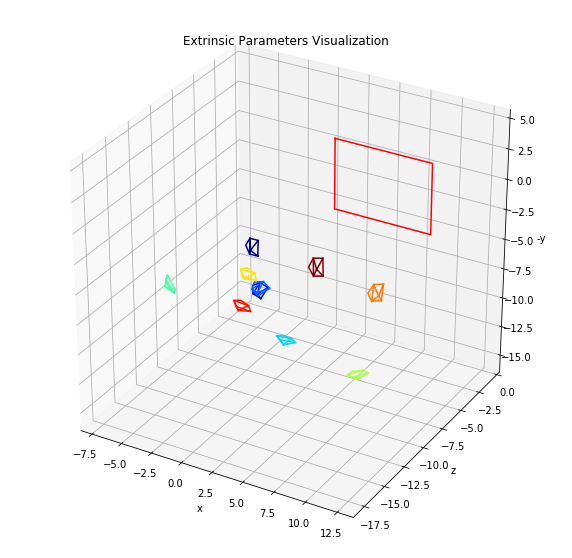

In [11]:
# show the camera extrinsics
print('Show the camera extrinsics')
# plot setting
# You can modify it for better visualization
fig = plt.figure(figsize=(10, 10))
ax = fig.gca(projection='3d')
# camera setting
camera_matrix = mtx
cam_width = 0.064/0.1
cam_height = 0.032/0.1
scale_focal = 1600
# chess board setting
board_width = 8
board_height = 6
square_size = 1
# display
# True -> fix board, moving cameras
# False -> fix camera, moving boards
min_values, max_values = show.draw_camera_boards(ax, camera_matrix, cam_width, cam_height,
                                                scale_focal, extrinsics, board_width,
                                                board_height, square_size, True)

X_min = min_values[0]
X_max = max_values[0]
Y_min = min_values[1]
Y_max = max_values[1]
Z_min = min_values[2]
Z_max = max_values[2]
max_range = np.array([X_max-X_min, Y_max-Y_min, Z_max-Z_min]).max() / 2.0

mid_x = (X_max+X_min) * 0.5
mid_y = (Y_max+Y_min) * 0.5
mid_z = (Z_max+Z_min) * 0.5
ax.set_xlim(mid_x - max_range, mid_x + max_range)
ax.set_ylim(mid_y - max_range, 0)
ax.set_zlim(mid_z - max_range, mid_z + max_range)

ax.set_xlabel('x')
ax.set_ylabel('z')
ax.set_zlabel('-y')
ax.set_title('Extrinsic Parameters Visualization')
plt.show()

#animation for rotating plot

# for angle in range(0, 360):
#     ax.view_init(30, angle)
#     plt.draw()
#     plt.pause(.001)